In [1]:
import os
import numpy as np
import pandas as pd
import keras

Using CNTK backend


In [2]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

train.head()

,cuisine,id,ingredients
0,italian,0,"[penne, shallots, rice vinegar, fresh basil, g..."
1,greek,1,"[sugar, chopped walnuts, filo dough, chopped a..."
2,italian,2,"[fresh rosemary, chopped fresh thyme, fresh or..."
3,southern_us,3,"[sugar, hot sauce, ramps, vinegar, cream chees..."
4,french,4,"[ground cinnamon, panettone, whipped cream, Am..."


In [19]:
def nospaces(str_array):
    fixers = ["tomato", "spinach", "ham", "mayonnaise", "lettuce",
              "butter", "pasta", "mustard", "avocado", "salami",
              "yogurt", "chocolate", "whiskey", "rice", "gelatin",
              "potato", "coffee", "beer", "bacon", "whisky", "curry",
              "asafetida", "gravy", "beef", "chicken", "pork", "bread",
              "cabbage", "celery", "almond", "apple", "milk", "cream",
              "carrot", "potatoe", "onion", "broccoli",
              "banana", "barbecue", "barley", "basil", "turkey",
              "cactus", "chile", "chili", "lamb", "lemon", "rum",
              "maple", "steak", "tomatoe", "liqueur", "citrus",
              "coconut", "cilantro", "chipotle", "ginger", "duck"]
    ingredients_nospaces = []
    for ingredients in str_array:
        ingredient_nospaces = []
        for ingredient in ingredients:
            ingredient = ingredient.replace("-", " ").lower().split()
            for item in fixers:
                if item in ingredient or item + "s" in ingredient:
                    ingredient = [item]
                    continue
            if len(ingredient) > 0:
                ingredient_nospaces.append("_".join(ingredient[-2:]))
            else:
                ingredient_nospaces.append(ingredient)
        ingredients_nospaces.append(ingredient_nospaces)
    return ingredients_nospaces

train["ingredients_nospaces"] = nospaces(train["ingredients"])
train['ingredients_string'] = train['ingredients_nospaces'].map(";".join)

test["ingredients_nospaces"] = nospaces(test["ingredients"])
test['ingredients_string'] = test['ingredients_nospaces'].map(";".join)

In [20]:
ingredients_unique = []
for ingredients in train["ingredients_nospaces"]:
    for ingredient in ingredients:
        if ingredient in ingredients_unique:
            continue
        ingredients_unique.append(ingredient)
for ingredient in sorted(ingredients_unique):
    print(ingredient)
print(len(ingredients_unique))

&_half
&_marinade
&_sauce
00_flour
5_spice
7_up
8_juice
abalone
abbamele
absinthe
abura_age
acai_juice
acai_puree
accent
accent_seasoning
accompaniment
achiote
achiote_paste
achiote_powder
acid_powder
ackee
acorn_squash
adobo
adobo_sauce
adobo_seasoning
adzuki_beans
agar
agar_flakes
agave_nectar
agave_tequila
aged_gouda
ahi
aioli
ajinomoto
ajwain
aka_miso
albacore
alcohol
ale
aleppo
aleppo_pepper
alfalfa_sprouts
alfredo_sauc
alfredo_sauce
allspice
allspice_berries
almond
alum
amaranth
amarena_cherries
amaretti
amaretti_cookies
amaretto
amber
amberjack_fillet
amchur
america
american_cheese
ammonium_bicarbonate
amontillado_sherry
ampalaya
anasazi_beans
ancho
ancho_powder
anchovies
anchovy_filets
anchovy_fillets
anchovy_paste
and_annatto
and_chop
and_chopped
and_crumbled
and_devein
and_drain
and_drained
and_flake
and_half
and_toasted
and_undiluted
andouille_sausage
angel_hair
angled_loofah
angostura_bitters
anise
anise_extract
anise_oil
anise_powder
anise_seed
anisette
anjou_pears
annatto

parmesan_romano
parmigiana_reggiano
parmigiano
parslei_minicub
parsley
parsley_flakes
parsley_leaves
parsley_root
parsley_sprigs
parsnips
pasilla
pasilla_pepper
passata
passion_fruit
passover_wine
pasta
paste_color
pastina
pastis
pastry
pastry_cups
pastry_dough
pastry_flour
pastry_sheets
pastry_shell
patis
pattypan_squash
pea_eggplants
pea_pods
pea_shoots
peach_juice
peach_nectar
peach_preserves
peach_salsa
peach_schnapps
peach_slices
peach_sorbet
peach_vodka
peaches
peanut_brittle
peanut_oil
peanut_powder
peanut_sauce
peanuts
peapods
pear_juice
pear_nectar
pearl_couscous
pearl_tapioca
pearled_farro
pears
peas
pecan_halves
pecan_meal
pecan_pie
pecans
pecorino_cheese
pectin
peeled_prawns
peeled_shrimp
pekoe_tea
penne
penne_rigate
penne_ziti
peperoncini
peperoncino
pepitas
peppadews
pepper
pepper,_slice
pepper,_sliced
pepper_cheese
pepper_flakes
pepper_jack
pepper_leaves
pepper_rings
pepper_sauce
pepper_seasoning
peppercorn_oil
peppercorns
peppermint_candy
peppermint_extract
pepperocini


In [21]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X = cv.fit_transform(train['ingredients_string'].values)

In [22]:
def tonums(str_array, cv):
    ingredients_nums = []
    for ingredients in str_array:
        ingredient_nums = []
        for ingredient in ingredients:
            try:
                ingredient_nums.append(cv.vocabulary_[ingredient])
            except:
                ingredient_nums.append(-1)
        ingredients_nums.append(ingredient_nums)
    return ingredients_nums

train["ingredients_nums"] = tonums(train["ingredients_nospaces"], cv)
test["ingredients_nums"] = tonums(test["ingredients_nospaces"], cv)

In [23]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

y = enc.fit_transform(train["cuisine"])
train["cuisine_nums"] = y

In [24]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train["ingredients_nums"], 29774)
x_test = vectorize_sequences(test["ingredients_nums"], 29774)

In [25]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train["cuisine_nums"], 20)

In [26]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(29774,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

In [27]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = one_hot_train_labels[:10000]
partial_y_train = one_hot_train_labels[10000:]

In [29]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=8,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 19774 samples, validate on 10000 samples
Epoch 1/8


D:\Software\Anaconda3\envs\cntk-py36\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input2436") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
D:\Software\Anaconda3\envs\cntk-py36\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input2379") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


19774/19774 [==============================] - 35s - loss: 2.0519 - acc: 0.4973 - val_loss: 1.5047 - val_acc: 0.6033
Epoch 2/8
19774/19774 [==============================] - 16s - loss: 1.2408 - acc: 0.6662 - val_loss: 1.0992 - val_acc: 0.6952
Epoch 3/8
19774/19774 [==============================] - 15s - loss: 0.9376 - acc: 0.7408 - val_loss: 0.9493 - val_acc: 0.7296
Epoch 4/8
19774/19774 [==============================] - 15s - loss: 0.7961 - acc: 0.7765 - val_loss: 0.8867 - val_acc: 0.7452
Epoch 5/8
19774/19774 [==============================] - 15s - loss: 0.7113 - acc: 0.7977 - val_loss: 0.8540 - val_acc: 0.7524
Epoch 6/8
19774/19774 [==============================] - 15s - loss: 0.6518 - acc: 0.8120 - val_loss: 0.8424 - val_acc: 0.7540
Epoch 7/8
19774/19774 [==============================] - 16s - loss: 0.6078 - acc: 0.8218 - val_loss: 0.8318 - val_acc: 0.7558
Epoch 8/8
19774/19774 [==============================] - 18s - loss: 0.5710 - acc: 0.8318 - val_loss: 0.8333 - val_acc: 0

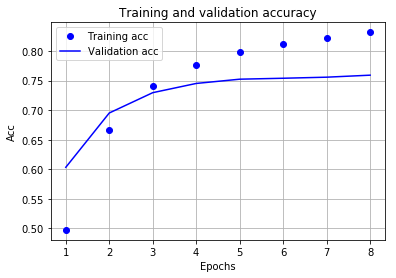

In [30]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.grid()

plt.show()

In [31]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(29774,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=7,
          batch_size=512,
          validation_data=(x_val, y_val))

Train on 19774 samples, validate on 10000 samples
Epoch 1/7


D:\Software\Anaconda3\envs\cntk-py36\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input3222") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
D:\Software\Anaconda3\envs\cntk-py36\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input3165") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


19774/19774 [==============================] - 17s - loss: 1.9501 - acc: 0.5333 - val_loss: 1.3854 - val_acc: 0.6243
Epoch 2/7
19774/19774 [==============================] - 16s - loss: 1.1503 - acc: 0.6848 - val_loss: 1.0423 - val_acc: 0.7100
Epoch 3/7
19774/19774 [==============================] - 16s - loss: 0.8892 - acc: 0.7465 - val_loss: 0.9328 - val_acc: 0.7280
Epoch 4/7
19774/19774 [==============================] - 17s - loss: 0.7636 - acc: 0.7796 - val_loss: 0.8731 - val_acc: 0.7416
Epoch 5/7
19774/19774 [==============================] - 16s - loss: 0.6832 - acc: 0.8020 - val_loss: 0.8464 - val_acc: 0.7549
Epoch 6/7
19774/19774 [==============================] - 16s - loss: 0.6278 - acc: 0.8169 - val_loss: 0.8295 - val_acc: 0.7593
Epoch 7/7
19774/19774 [==============================] - 16s - loss: 0.5808 - acc: 0.8322 - val_loss: 0.8322 - val_acc: 0.7579


In [32]:
final_submission = pd.DataFrame()
final_submission['id'] = test["id"]

predictions = model.predict(x_test)

def num_to_string(num_array, enc):
    string_cuisine = []
    for num in num_array:
        string_cuisine.append(enc.classes_[num])
    return string_cuisine
        
final_submission['cuisine'] = num_to_string(predictions.argmax(1), enc)

final_submission.to_csv('submission.csv', index=False)

D:\Software\Anaconda3\envs\cntk-py36\lib\site-packages\cntk\core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input3165") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))
